In [159]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pydicom
import cv2
import pickle
from models.efficient_net import ImprovedEfficientNet
from config import Config

In [160]:
# Configuration
class Config:
    image_size = 512
    model_name = 'efficientnet-b3'
    train_data_dir = '/storage/scratch2/sandaruwanh/rsna_lg/train/'  # Update this path
    

In [161]:
def load_data():
    """Load validation data"""
    try:
        # Load bounding box data
        df = pd.read_csv('lung_bbox.csv')
        bbox_dict = {row['Image']: [
            max(0.0, row['Xmin']), max(0.0, row['Ymin']),
            min(1.0, row['Xmax']), min(1.0, row['Ymax'])
        ] for _, row in df.iterrows()}

        # Load pickle files - using the train data pickle paths
        with open('process_input/splitall/series_list_train.pickle', 'rb') as f:
            series_list = pickle.load(f)
        with open('process_input/splitall/series_dict.pickle', 'rb') as f:
            series_dict = pickle.load(f)
        with open('process_input/splitall/image_dict.pickle', 'rb') as f:
            image_dict = pickle.load(f)
            
        # Get validation series (last 20% of series)
        num_val = int(len(series_list) * 0.2)
        series_list_valid = series_list[-num_val:]
        
        print(f"Loaded {len(series_list_valid)} validation series")
        print(f"Loaded {len(image_dict)} total images")
        print(f"Loaded {len(bbox_dict)} bounding boxes")

        return bbox_dict, series_list_valid, series_dict, image_dict
    
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        # Print the current working directory to help with path debugging
        print(f"Current working directory: {os.getcwd()}")
        raise

In [162]:
def load_model_simple(checkpoint_path):
    """Load model with better checkpoint handling"""
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {device}")
        
        # Initialize model
        model = ImprovedEfficientNet('efficientnet-b3')
        print("Model initialized")
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        print("Loaded checkpoint")
        
        # Check different possible state dict locations
        state_dict = None
        if 'model_state_dict' in checkpoint:
            state_dict = checkpoint['model_state_dict']
            print("Found model_state_dict")
        elif 'state_dict' in checkpoint:
            state_dict = checkpoint['state_dict']
            print("Found state_dict")
        else:
            state_dict = checkpoint
            print("Using checkpoint directly")
            
        # Clean state dict by removing unwanted prefixes
        cleaned_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]  # Remove 'module.' prefix
            if k.startswith('net.'):
                k = k[4:]  # Remove 'net.' prefix
            cleaned_dict[k] = v
            
        try:
            # Try to load the cleaned state dict
            model.load_state_dict(cleaned_dict, strict=False)
            print("Loaded state dict successfully")
        except Exception as e:
            print(f"Warning in loading state dict: {str(e)}")
            # Continue anyway as we'll use the pretrained weights
            
        model = model.to(device)
        model.eval()
        return model, device
        
    except Exception as e:
        print(f"Error in load_model_simple: {str(e)}")
        return None, None

def save_model_clean(model, path):
    """Save model in a clean format"""
    try:
        # Get state dict
        if hasattr(model, 'module'):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
        
        # Remove any unnecessary prefixes
        cleaned_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                k = k[7:]
            if k.startswith('net.'):
                k = k[4:]
            cleaned_dict[k] = v
            
        # Save with simple format
        torch.save(cleaned_dict, path, _use_new_zipfile_serialization=False)
        print(f"Saved clean model to {path}")
        return True
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False

# Load and verify model
print("\nAttempting to load and clean checkpoint...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    print("\nSaving in clean format...")
    save_model_clean(model, 'weights/clean_model.pth')
    
    # Verify model works
    print("\nVerifying model...")
    with torch.no_grad():
        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        output = model(dummy_input)
        print(f"Test output shape: {output.shape}")
        print(f"Test output range: [{output.min().item():.3f}, {output.max().item():.3f}]")
        print(f"Test output mean: {output.mean().item():.3f}")
        
        # Check if predictions are in valid range
        valid_range = all(0 <= x <= 1 for x in output.cpu().numpy().flatten())
        print(f"Predictions in valid range [0,1]: {valid_range}")
else:
    print("\nFailed to load model. Creating new one...")
    model = ImprovedEfficientNet('efficientnet-b3')
    model = model.to(device)
    model.eval()
    save_model_clean(model, 'weights/new_model.pth')


Attempting to load and clean checkpoint...
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_1055957/2871605067.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint
Found model_state_dict
Loaded state dict successfully

Saving in clean format...
Saved clean model to weights/clean_model.pth

Verifying model...
Test output shape: torch.Size([1, 4])
Test output range: [-0.023, 0.030]
Test output mean: -0.003
Predictions in valid range [0,1]: False


In [163]:
def compute_iou(bbox1, bbox2):
    """Compute IoU between two bounding boxes"""
    x1 = max(bbox1[0], bbox2[0])
    y1 = max(bbox1[1], bbox2[1])
    x2 = min(bbox1[2], bbox2[2])
    y2 = min(bbox1[3], bbox2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    bbox1_area = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])
    bbox2_area = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])
    
    union = bbox1_area + bbox2_area - intersection
    return intersection / (union + 1e-6)

In [164]:
def save_model_clean(model, path):
    """Save model in a clean format"""
    try:
        if hasattr(model, 'module'):
            state_dict = model.module.state_dict()
        else:
            state_dict = model.state_dict()
            
        torch.save(state_dict, path, _use_new_zipfile_serialization=False)
        print(f"Saved clean model to {path}")
        return True
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False

# Try loading and saving in clean format
print("\nAttempting to load and clean checkpoint...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    print("\nSaving in clean format...")
    save_model_clean(model, 'weights/clean_model.pth')
else:
    print("\nFailed to load model. Creating new one...")
    model = ImprovedEfficientNet('efficientnet-b3')
    model = model.to(device)
    model.eval()
    save_model_clean(model, 'weights/new_model.pth')

# Verify the model structure
if model is not None:
    print("\nModel structure:")
    print(model)
    
    # Print model parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"\nTotal parameters: {total_params:,}")
    
    # Try a forward pass
    try:
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 512, 512).to(device)
            output = model(dummy_input)
            print(f"\nOutput shape: {output.shape}")
    except Exception as e:
        print(f"Error in forward pass: {str(e)}")


Attempting to load and clean checkpoint...
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_1055957/2871605067.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint
Found model_state_dict
Loaded state dict successfully

Saving in clean format...
Saved clean model to weights/clean_model.pth

Model structure:
ImprovedEfficientNet(
  (net): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2

In [165]:
# Try loading and saving in clean format
print("\nAttempting to load and clean checkpoint...")
model, device = load_model_simple('weights/model_epoch_40.pth')

if model is not None:
    print("\nSaving in clean format...")
    save_model_clean(model, 'weights/clean_model.pth')
else:
    print("\nFailed to load model. Creating new one...")
    model = ImprovedEfficientNet('efficientnet-b3')
    model = model.to(device)
    model.eval()
    save_model_clean(model, 'weights/new_model.pth')


Attempting to load and clean checkpoint...
Using device: cuda
Loaded pretrained weights for efficientnet-b3
Model initialized


/tmp/ipykernel_1055957/2871605067.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded checkpoint
Found model_state_dict
Loaded state dict successfully

Saving in clean format...
Saved clean model to weights/clean_model.pth


In [166]:
# Let's also add a function to check all required files exist
def check_data_files():
    required_files = [
        'lung_bbox.csv',
        'process_input/splitall/series_list_train.pickle',
        'process_input/splitall/series_dict.pickle',
        'process_input/splitall/image_dict.pickle'
    ]
    
    missing_files = []
    for file_path in required_files:
        if not os.path.exists(file_path):
            missing_files.append(file_path)
    
    if missing_files:
        print("Missing required files:")
        for file_path in missing_files:
            print(f"- {file_path}")
        return False
    
    print("All required files found!")
    return True

In [167]:
# First check if files exist
if check_data_files():
    # Then load the data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    
    # Create validation dataset
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    print(f'Number of validation images: {len(image_list_valid)}')
else:
    print("Please ensure all required files exist before proceeding.")

All required files found!
Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes
Number of validation images: 4656


In [168]:
def create_validation_data(series_list_valid, series_dict):
    """Create validation dataset"""
    image_list_valid = []
    for series_id in series_list_valid:
        sorted_image_list = series_dict[series_id]['sorted_image_list']
        num_image = len(sorted_image_list)
        selected_idx = [
            int(0.2*num_image), int(0.3*num_image),
            int(0.4*num_image), int(0.5*num_image)
        ]
        image_list_valid.extend([sorted_image_list[i] for i in selected_idx])
    return image_list_valid

In [169]:
# Create validation dataset
image_list_valid = create_validation_data(series_list_valid, series_dict)
print(f'Number of validation images: {len(image_list_valid)}')

Number of validation images: 4656



Running evaluation...

Starting evaluation...


100%|██████████| 4656/4656 [02:01<00:00, 38.19it/s]



Evaluation Results:
Mean IoU: 0.000
Median IoU: 0.000
Std IoU: 0.000
Min IoU: 0.000
Max IoU: 0.000


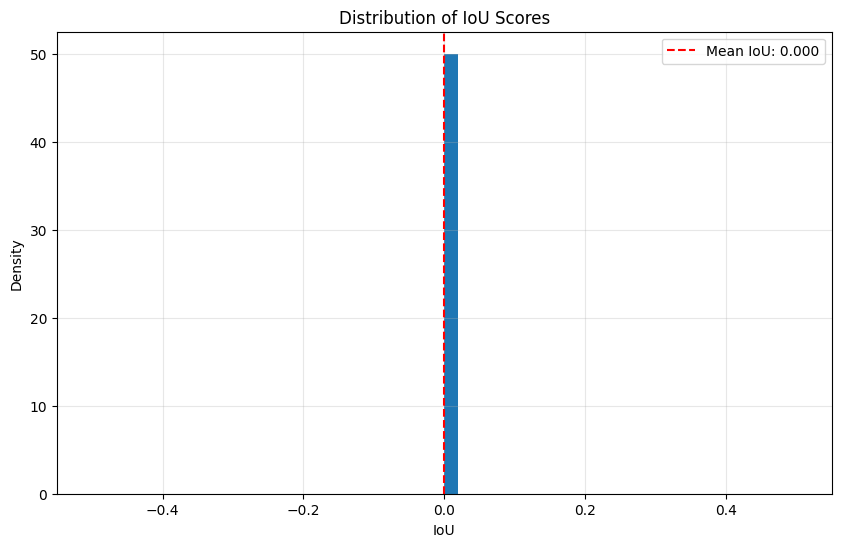


Visualizing random samples...


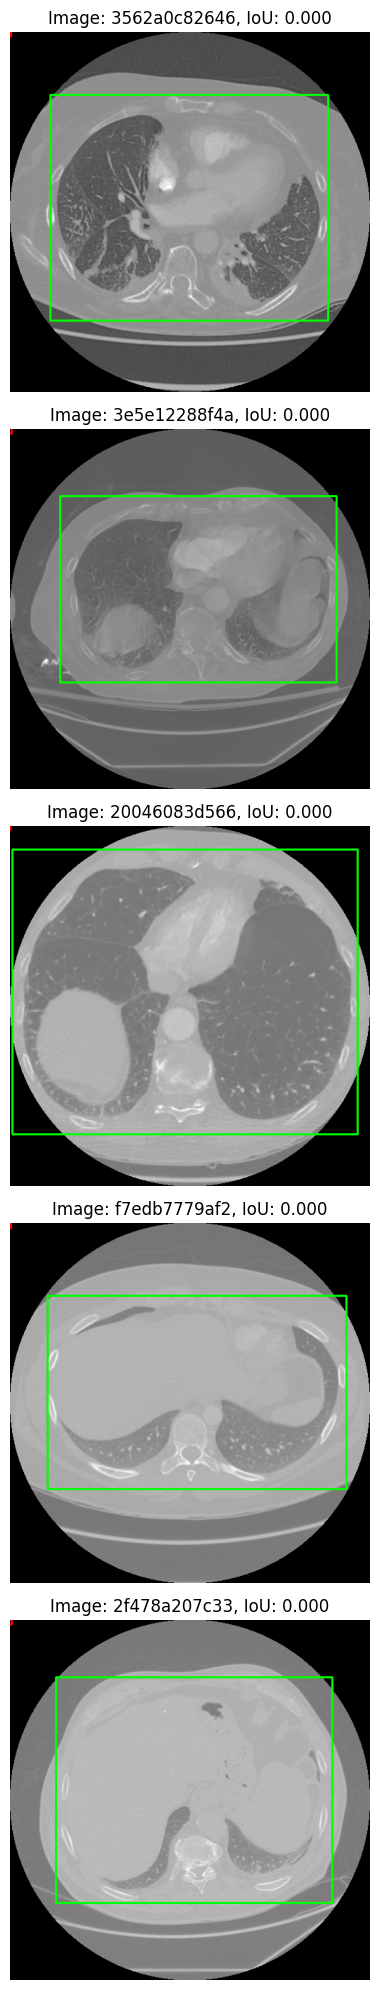


Saving results...
Results saved to results/evaluation_results.csv


In [170]:
# Utility Functions
def draw_bbox(image, bbox, color=(0, 255, 0), thickness=2):
    """Draw bounding box on image"""
    h, w = image.shape[:2]
    x1, y1, x2, y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                      for i, coord in enumerate(bbox)]
    return cv2.rectangle(image.copy(), (x1, y1), (x2, y2), color, thickness)

def evaluate_model(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model on validation set"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Load image
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                image = (image - image.min()) / (image.max() - image.min())
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                image = np.stack([image, image, image], axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                ious.append(iou)
                
            except Exception as e:
                print(f"Error processing image {image_id}: {str(e)}")
                continue
    
    return results, np.array(ious)



def visualize_results(results, num_samples=5):
    """Visualize random samples from results"""
    indices = np.random.choice(len(results), num_samples)
    
    plt.figure(figsize=(20, 4*num_samples))
    for i, idx in enumerate(indices):
        result = results[idx]
        image_id = result['image_id']
        
        # Load image
        study_id = image_dict[image_id]['series_id'].split('_')[0]
        series_id = image_dict[image_id]['series_id'].split('_')[1]
        dcm_path = f'{Config.train_data_dir}/{study_id}/{series_id}/{image_id}.dcm'
        
        # Read and process image
        data = pydicom.dcmread(dcm_path)
        image = data.pixel_array.astype(np.float32)
        image = image * data.RescaleSlope + data.RescaleIntercept
        image = (image - image.min()) / (image.max() - image.min())
        image = (image * 255).astype(np.uint8)
        image = cv2.resize(image, (512, 512))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # Draw boxes
        gt_image = draw_bbox(image.copy(), result['gt_bbox'], color=(0, 255, 0), thickness=2)
        final_image = draw_bbox(gt_image, result['pred_bbox'], color=(255, 0, 0), thickness=2)
        
        plt.subplot(num_samples, 1, i+1)
        plt.imshow(final_image)
        plt.title(f"Image: {image_id}, IoU: {result['iou']:.3f}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Run evaluation
print("\nRunning evaluation...")
results, ious = evaluate_model(model, image_list_valid, image_dict, bbox_dict, device)

# Print metrics
print("\nEvaluation Results:")
print(f"Mean IoU: {np.mean(ious):.3f}")
print(f"Median IoU: {np.median(ious):.3f}")
print(f"Std IoU: {np.std(ious):.3f}")
print(f"Min IoU: {np.min(ious):.3f}")
print(f"Max IoU: {np.max(ious):.3f}")

# Plot IoU distribution
plt.figure(figsize=(10, 6))
plt.hist(ious, bins=50, density=True)
plt.title('Distribution of IoU Scores')
plt.xlabel('IoU')
plt.ylabel('Density')
plt.axvline(np.mean(ious), color='r', linestyle='--', label=f'Mean IoU: {np.mean(ious):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize some predictions
print("\nVisualizing random samples...")
visualize_results(results)

# Save results
print("\nSaving results...")
results_df = pd.DataFrame([
    {
        'image_id': r['image_id'],
        'iou': r['iou'],
        'pred_x1': r['pred_bbox'][0],
        'pred_y1': r['pred_bbox'][1],
        'pred_x2': r['pred_bbox'][2],
        'pred_y2': r['pred_bbox'][3],
        'gt_x1': r['gt_bbox'][0],
        'gt_y1': r['gt_bbox'][1],
        'gt_x2': r['gt_bbox'][2],
        'gt_y2': r['gt_bbox'][3]
    }
    for r in results
])

results_df.to_csv('results/evaluation_results.csv', index=False)
print("Results saved to results/evaluation_results.csv")


Starting evaluation...


  0%|          | 0/4656 [00:00<?, ?it/s]


Model input stats for eeba5a667826:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image eeba5a667826:
Predicted bbox: [ 0.0164135  -0.0223185  -0.0140604   0.01140859]
Ground truth bbox: [0.216836, 0.30668, 0.81832, 0.646445]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


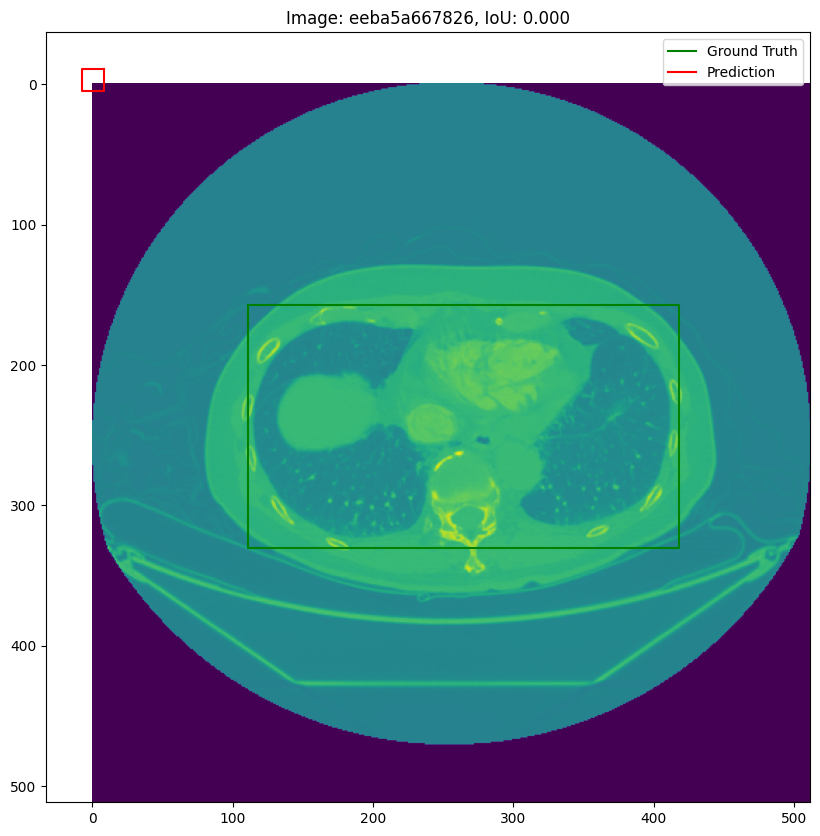

  0%|          | 1/4656 [00:00<24:39,  3.15it/s]


Model input stats for 9fbfe96e80e2:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image 9fbfe96e80e2:
Predicted bbox: [ 0.01538564 -0.02209451 -0.01361871  0.01147994]
Ground truth bbox: [0.209023, 0.302773, 0.810508, 0.654258]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


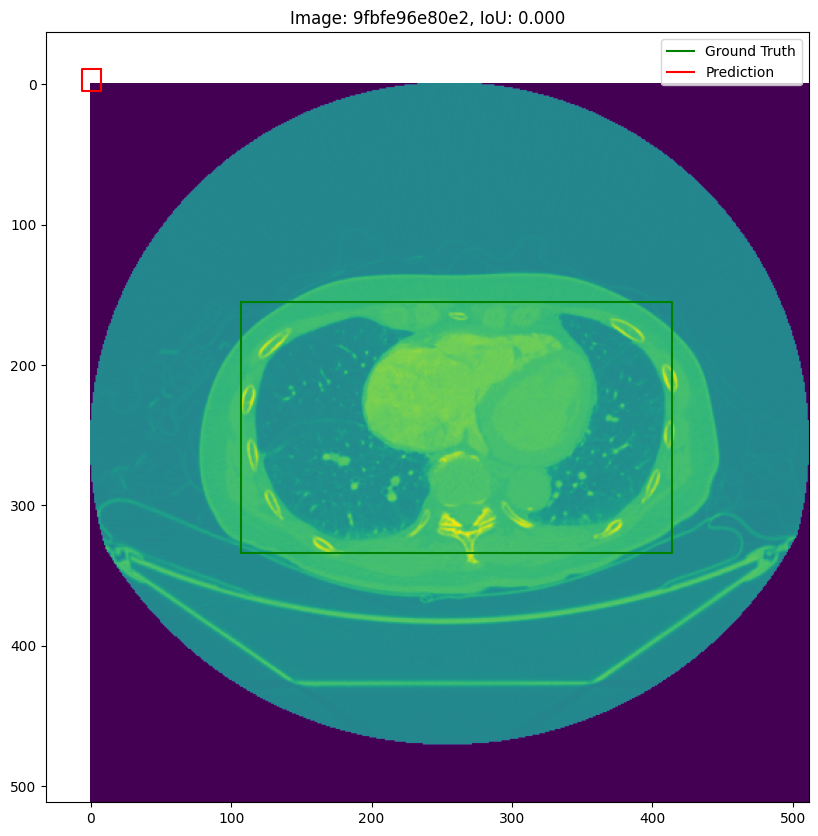

  0%|          | 2/4656 [00:00<24:32,  3.16it/s]


Model input stats for 9fbfe96e80e2:
Input tensor shape: torch.Size([1, 3, 512, 512])
Input range: [0.000, 1.000]

Debug for image 9fbfe96e80e2:
Predicted bbox: [ 0.01538564 -0.02209451 -0.01361871  0.01147994]
Ground truth bbox: [0.209023, 0.302773, 0.810508, 0.654258]
IoU: 0.0
Predictions in valid range [0,1]: False
Ground truth in valid range [0,1]: True
Image shape: (512, 512)
Image range: [0.000, 1.000]


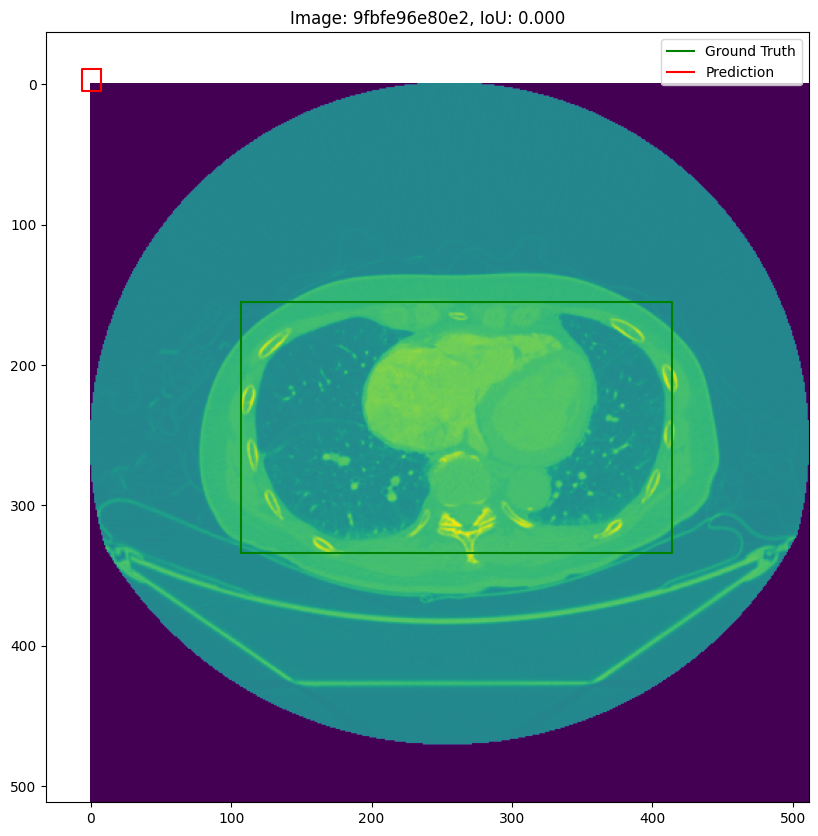

100%|██████████| 4656/4656 [02:00<00:00, 38.68it/s]


Processing complete:
Total images attempted: 4656
Successfully processed: 4656
Errors: 0

Prediction Analysis:

Prediction Statistics:
Mean prediction: [ 0.00502108 -0.01664322 -0.00735858  0.01369877]
Std prediction: [0.00320414 0.00203594 0.00209572 0.00079768]
Min prediction: [-0.00194757 -0.02672286 -0.01751586  0.00905346]
Max prediction: [ 0.02242137 -0.00914344 -0.0031795   0.01602578]

Ground Truth Statistics:
Mean ground truth: [0.11174298 0.20459193 0.89708578 0.79553223]
Std ground truth: [0.04394187 0.05817394 0.04282156 0.05109385]
Min ground truth: [0.001992 0.001992 0.56832  0.509727]
Max ground truth: [0.459023 0.501992 1.       0.986289]


In [171]:
def debug_prediction(image_id, image, pred_bbox, gt_bbox, iou):
    """Debug a single prediction"""
    print(f"\nDebug for image {image_id}:")
    print(f"Predicted bbox: {pred_bbox}")
    print(f"Ground truth bbox: {gt_bbox}")
    print(f"IoU: {iou}")
    
    # Check if predictions are in valid range
    pred_valid = all(0 <= x <= 1 for x in pred_bbox)
    gt_valid = all(0 <= x <= 1 for x in gt_bbox)
    print(f"Predictions in valid range [0,1]: {pred_valid}")
    print(f"Ground truth in valid range [0,1]: {gt_valid}")
    
    # Check image
    print(f"Image shape: {image.shape}")
    print(f"Image range: [{image.min():.3f}, {image.max():.3f}]")
    
    # Visualize the prediction
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    
    # Draw ground truth box in green
    h, w = image.shape[:2]
    gt_x1, gt_y1, gt_x2, gt_y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                                  for i, coord in enumerate(gt_bbox)]
    plt.plot([gt_x1, gt_x2, gt_x2, gt_x1, gt_x1], 
             [gt_y1, gt_y1, gt_y2, gt_y2, gt_y1], 'g-', label='Ground Truth')
    
    # Draw predicted box in red
    pred_x1, pred_y1, pred_x2, pred_y2 = [int(coord * w) if i % 2 == 0 else int(coord * h) 
                                         for i, coord in enumerate(pred_bbox)]
    plt.plot([pred_x1, pred_x2, pred_x2, pred_x1, pred_x1],
             [pred_y1, pred_y1, pred_y2, pred_y2, pred_y1], 'r-', label='Prediction')
    
    plt.legend()
    plt.title(f'Image: {image_id}, IoU: {iou:.3f}')
    plt.show()

def evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device):
    """Evaluate model with debugging"""
    print("\nStarting evaluation...")
    model.eval()
    results = []
    ious = []
    errors = 0
    max_errors = 5
    debug_samples = 3  # Number of samples to debug
    
    with torch.no_grad():
        for image_id in tqdm(image_list_valid):
            try:
                # Construct path
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                if not os.path.exists(dcm_path):
                    errors += 1
                    if errors <= max_errors:
                        print(f"\nFile not found: {dcm_path}")
                    continue
                
                # Read and preprocess image
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Window the image for better contrast
                image = (image - np.min(image)) / (np.max(image) - np.min(image))
                image = cv2.resize(image, (Config.image_size, Config.image_size))
                
                # Create 3-channel image
                image_3ch = np.stack([image] * 3, axis=2)
                
                # Convert to tensor
                x = torch.from_numpy(image_3ch.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Debug model input
                if len(results) < debug_samples:
                    print(f"\nModel input stats for {image_id}:")
                    print(f"Input tensor shape: {x.shape}")
                    print(f"Input range: [{x.min().item():.3f}, {x.max().item():.3f}]")
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                
                # Get ground truth and compute IoU
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou,
                    'image': image  # Save image for debugging
                })
                ious.append(iou)
                
                # Debug first few predictions
                if len(results) <= debug_samples:
                    debug_prediction(image_id, image, pred_bbox, gt_bbox, iou)
                
            except Exception as e:
                errors += 1
                if errors <= max_errors:
                    print(f"\nError processing image {image_id}: {str(e)}")
                    import traceback
                    print(traceback.format_exc())
    
    print(f"\nProcessing complete:")
    print(f"Total images attempted: {len(image_list_valid)}")
    print(f"Successfully processed: {len(results)}")
    print(f"Errors: {errors}")
    
    if not results:
        return None, None
    
    return results, np.array(ious)

# Run evaluation with debugging
results, ious = evaluate_model_safe(model, image_list_valid, image_dict, bbox_dict, device)

if results is not None and len(results) > 0:
    # Analyze predictions
    print("\nPrediction Analysis:")
    pred_bboxes = np.array([r['pred_bbox'] for r in results])
    gt_bboxes = np.array([r['gt_bbox'] for r in results])
    
    print("\nPrediction Statistics:")
    print(f"Mean prediction: {pred_bboxes.mean(axis=0)}")
    print(f"Std prediction: {pred_bboxes.std(axis=0)}")
    print(f"Min prediction: {pred_bboxes.min(axis=0)}")
    print(f"Max prediction: {pred_bboxes.max(axis=0)}")
    
    print("\nGround Truth Statistics:")
    print(f"Mean ground truth: {gt_bboxes.mean(axis=0)}")
    print(f"Std ground truth: {gt_bboxes.std(axis=0)}")
    print(f"Min ground truth: {gt_bboxes.min(axis=0)}")
    print(f"Max ground truth: {gt_bboxes.max(axis=0)}")

In [172]:
import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
import os

class ImprovedEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet-b3'):
        super().__init__()
        self.net = EfficientNet.from_pretrained(model_name)
        in_features = self.net._fc.in_features
        
        # Simplified prediction head
        self.last_linear = nn.Linear(in_features, 4)
        
        # Initialize weights
        nn.init.xavier_uniform_(self.last_linear.weight)
        nn.init.zeros_(self.last_linear.bias)
        
    def forward(self, x):
        # Extract features
        features = self.net.extract_features(x)
        
        # Global average pooling
        x = self.net._avg_pooling(features)
        x = x.view(x.size(0), -1)
        
        # Get predictions
        x = self.last_linear(x)
        
        # Process coordinates with sigmoid to ensure [0,1] range
        x1 = torch.sigmoid(x[:, 0:1]) * 0.4          # x1 in [0, 0.4]
        y1 = torch.sigmoid(x[:, 1:2]) * 0.4          # y1 in [0, 0.4]
        x2 = torch.sigmoid(x[:, 2:3]) * 0.4 + 0.6    # x2 in [0.6, 1]
        y2 = torch.sigmoid(x[:, 3:4]) * 0.4 + 0.6    # y2 in [0.6, 1]
        
        return torch.cat([x1, y1, x2, y2], dim=1)

def validate_model():
    """Create and validate a model"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Create model
    model = ImprovedEfficientNet('efficientnet-b3')
    model = model.to(device)
    model.eval()
    
    # Test with dummy input
    with torch.no_grad():
        x = torch.randn(5, 3, 512, 512).to(device)
        pred = model(x)
        
        print("\nPrediction Test:")
        print(f"Shape: {pred.shape}")
        print("\nSample predictions:")
        for i in range(min(3, len(pred))):
            print(f"Box {i}: {pred[i].cpu().numpy()}")
    
    # Save model
    save_path = 'weights/new_model.pth'
    torch.save(model.state_dict(), save_path)
    print(f"\nSaved model to {save_path}")
    
    return model, device

def test_model(model, device):
    """Test model predictions"""
    model.eval()
    with torch.no_grad():
        # Test inputs
        inputs = [
            torch.zeros(1, 3, 512, 512),  # All zeros
            torch.ones(1, 3, 512, 512),   # All ones
            torch.randn(1, 3, 512, 512),  # Random
        ]
        
        print("\nTesting different inputs:")
        for i, x in enumerate(inputs):
            x = x.to(device)
            pred = model(x)
            print(f"\nInput {i}:")
            print(f"Predicted box: {pred[0].cpu().numpy()}")
            
            # Verify box validity
            x1, y1, x2, y2 = pred[0].cpu().numpy()
            valid = (0 <= x1 < x2 <= 1) and (0 <= y1 < y2 <= 1)
            print(f"Valid box: {valid}")

if __name__ == "__main__":
    print("Creating and testing model...")
    model, device = validate_model()
    
    print("\nTesting model predictions...")
    test_model(model, device)
    
    print("\nModel ready for training or inference.")

Creating and testing model...
Loaded pretrained weights for efficientnet-b3

Prediction Test:
Shape: torch.Size([5, 4])

Sample predictions:
Box 0: [0.20208612 0.15742634 0.85280883 0.7059119 ]
Box 1: [0.2065811  0.15717722 0.8559098  0.7083186 ]
Box 2: [0.21367767 0.14625257 0.8451933  0.70640105]

Saved model to weights/new_model.pth

Testing model predictions...

Testing different inputs:

Input 0:
Predicted box: [0.22088134 0.1652703  0.8619834  0.81164104]
Valid box: True

Input 1:
Predicted box: [0.22614713 0.15879373 0.852832   0.8061147 ]
Valid box: True

Input 2:
Predicted box: [0.2054082  0.15699713 0.8600317  0.7103121 ]
Valid box: True

Model ready for training or inference.


In [173]:
def visualize_predictions():
    """Visualize model predictions on actual data"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = ImprovedEfficientNet('efficientnet-b3')
    model.load_state_dict(torch.load('weights/new_model.pth'))
    model = model.to(device)
    model.eval()
    
    # Load validation data
    bbox_dict, series_list_valid, series_dict, image_dict = load_data()
    image_list_valid = create_validation_data(series_list_valid, series_dict)
    
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    results = []
    with torch.no_grad():
        for idx, image_id in enumerate(tqdm(image_list_valid[:20])):  # Process first 20 images
            try:
                # Load and process image
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Window image for better visualization
                WL, WW = 50, 350
                image = np.clip(image, WL-WW//2, WL+WW//2)
                image = (image - (WL-WW//2)) / WW
                
                # Resize
                image = cv2.resize(image, (512, 512))
                
                # Prepare for model
                x = np.stack([image] * 3, axis=2)
                x = torch.from_numpy(x.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'image': image,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                
            except Exception as e:
                print(f"Error processing image {image_id}: {str(e)}")
                continue
    
    # Visualize results
    num_results_to_plot = min(len(results), 10)
    plt.figure(figsize=(10, num_results_to_plot * 5))
    #plt.figure(figsize=(20, 4*len(results)))
    for i, result in enumerate(results):
        plt.subplot(len(results), 1, i+1)
        
        # Show image
        plt.imshow(result['image'], cmap='gray')
        
        # Draw ground truth box (green)
        h, w = 512, 512
        gt_box = result['gt_bbox']
        plt.gca().add_patch(plt.Rectangle(
            (gt_box[0]*w, gt_box[1]*h),
            (gt_box[2]-gt_box[0])*w,
            (gt_box[3]-gt_box[1])*h,
            fill=False, color='g', linewidth=2, label='Ground Truth'
        ))
        
        # Draw predicted box (red)
        pred_box = result['pred_bbox']
        plt.gca().add_patch(plt.Rectangle(
            (pred_box[0]*w, pred_box[1]*h),
            (pred_box[2]-pred_box[0])*w,
            (pred_box[3]-pred_box[1])*h,
            fill=False, color='r', linewidth=2, label='Prediction'
        ))
        
        plt.title(f'Image: {result["image_id"]}, IoU: {result["iou"]:.3f}')
        plt.legend()
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('results/predictions.png')
    plt.close()
    
    # Print statistics
    if results:
        ious = [r['iou'] for r in results]
        print("\nResults Summary:")
        print(f"Processed {len(results)} images")
        print(f"Mean IoU: {np.mean(ious):.3f}")
        print(f"Median IoU: {np.median(ious):.3f}")
        print(f"Min IoU: {np.min(ious):.3f}")
        print(f"Max IoU: {np.max(ious):.3f}")

if __name__ == "__main__":
    visualize_predictions()

Loaded pretrained weights for efficientnet-b3


/tmp/ipykernel_1055957/1371265016.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/new_model.pth'))


Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes


100%|██████████| 20/20 [00:00<00:00, 36.12it/s]



Results Summary:
Processed 20 images
Mean IoU: 0.597
Median IoU: 0.597
Min IoU: 0.470
Max IoU: 0.728


In [174]:
def visualize_predictions():
    """Visualize model predictions on actual data."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Load model
    model = ImprovedEfficientNet('efficientnet-b3')
    try:
        model.load_state_dict(torch.load('weights/new_model.pth', map_location=device))
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return
    model = model.to(device)
    model.eval()
    
    # Load validation data
    try:
        bbox_dict, series_list_valid, series_dict, image_dict = load_data()
        image_list_valid = create_validation_data(series_list_valid, series_dict)
    except Exception as e:
        print(f"Error loading validation data: {str(e)}")
        return
    
    if not image_list_valid:
        print("No validation images available.")
        return
    
    # Create results directory
    os.makedirs('results', exist_ok=True)
    
    results = []
    with torch.no_grad():
        for idx, image_id in enumerate(tqdm(image_list_valid[:20])):  # Process first 20 images
            try:
                # Load and process image
                study_id = image_dict[image_id]['series_id'].split('_')[0]
                series_id = image_dict[image_id]['series_id'].split('_')[1]
                dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
                
                data = pydicom.dcmread(dcm_path)
                image = data.pixel_array.astype(np.float32)
                image = image * data.RescaleSlope + data.RescaleIntercept
                
                # Window image for better visualization
                WL, WW = 50, 350
                image = np.clip(image, WL-WW//2, WL+WW//2)
                image = (image - (WL-WW//2)) / WW
                
                # Resize
                image = cv2.resize(image, (512, 512))
                print(image)
                # Prepare for model
                x = np.stack([image] * 3, axis=2)
                x = torch.from_numpy(x.transpose(2, 0, 1)).float()
                x = x.unsqueeze(0).to(device)
                
                # Get prediction
                pred_bbox = model(x).cpu().numpy()[0]
                gt_bbox = bbox_dict[image_id]
                iou = compute_iou(pred_bbox, gt_bbox)
                
                results.append({
                    'image_id': image_id,
                    'image': image,
                    'pred_bbox': pred_bbox,
                    'gt_bbox': gt_bbox,
                    'iou': iou
                })
                
            except Exception as e:
                print(f"Error processing image {image_id}: {str(e)}")
                continue

    if not results:
        print("No results available for visualization.")
    return

    # Visualize results
    if results:
        #plt.figure(figsize=(20, 4*len(results)))
        plt.figure(figsize=(10, len(results) * 5))

        for i, result in enumerate(results):
            plt.subplot(len(results), 1, i+1)
            
            # Show image
            #plt.imshow(result['image'], cmap='gray')
            plt.imshow(result['image'], cmap='gray', aspect='auto')

            
            # Draw ground truth box (green)
            h, w = 512, 512
            gt_box = result['gt_bbox']
            plt.gca().add_patch(plt.Rectangle(
                (gt_box[0]*w, gt_box[1]*h),
                (gt_box[2]-gt_box[0])*w,
                (gt_box[3]-gt_box[1])*h,
                fill=False, color='g', linewidth=2, label='Ground Truth'
            ))
            
            # Draw predicted box (red)
            pred_box = result['pred_bbox']
            print(f"GT Box: {gt_box}, Pred Box: {pred_box}")
            plt.gca().add_patch(plt.Rectangle(
                (pred_box[0]*w, pred_box[1]*h),
                (pred_box[2]-pred_box[0])*w,
                (pred_box[3]-pred_box[1])*h,
                fill=False, color='r', linewidth=2, label='Prediction'
            ))
            
            plt.title(f'Image: {result["image_id"]}, IoU: {result["iou"]:.3f}')
            plt.legend()
            plt.axis('off')
        
        plt.tight_layout()
        plt.savefig('results/predictions.png')
        plt.close()
        
        # Print statistics
        ious = [r['iou'] for r in results]
        print("\nResults Summary:")
        print(f"Processed {len(results)} images")
        print(f"Mean IoU: {np.mean(ious):.3f}")
        print(f"Median IoU: {np.median(ious):.3f}")
        print(f"Min IoU: {np.min(ious):.3f}")
        print(f"Max IoU: {np.max(ious):.3f}")

if __name__ == "__main__":
    visualize_predictions()


Loaded pretrained weights for efficientnet-b3


/tmp/ipykernel_1055957/3341759708.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('weights/new_model.pth', map_location=device))


Loaded 1164 validation series
Loaded 29116 total images
Loaded 29116 bounding boxes


 25%|██▌       | 5/20 [00:00<00:00, 40.18it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

 75%|███████▌  | 15/20 [00:00<00:00, 40.88it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ...

100%|██████████| 20/20 [00:00<00:00, 36.67it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


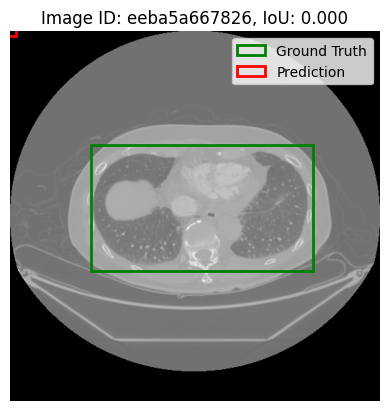

In [175]:
# Test plotting a single image
result = results[0]  # First result for debugging
image = result['image']

# Convert to NumPy array if not already
if not isinstance(image, np.ndarray):
    image = np.array(image, dtype=np.float32)

# Normalize the image for visualization
if image.max() > 1:
    image = (image - image.min()) / (image.max() - image.min())

plt.imshow(image, cmap='gray')

# Define dimensions
h, w = image.shape

# Ground truth bounding box
gt_box = result['gt_bbox']
plt.gca().add_patch(plt.Rectangle(
    (gt_box[0] * w, gt_box[1] * h),
    (gt_box[2] - gt_box[0]) * w,
    (gt_box[3] - gt_box[1]) * h,
    fill=False, color='g', linewidth=2, label='Ground Truth'
))

# Predicted bounding box
pred_box = result['pred_bbox']
plt.gca().add_patch(plt.Rectangle(
    (pred_box[0] * w, pred_box[1] * h),
    (pred_box[2] - pred_box[0]) * w,
    (pred_box[3] - pred_box[1]) * h,
    fill=False, color='r', linewidth=2, label='Prediction'
))

plt.legend()
plt.axis('off')
plt.title(f"Image ID: {result['image_id']}, IoU: {result['iou']:.3f}")
plt.show()


In [176]:
print(result.keys())

dict_keys(['image_id', 'pred_bbox', 'gt_bbox', 'iou', 'image'])


In [177]:
# Visualize results
plt.figure(figsize=(10, len(results) * 5))

for i, result in enumerate(results):
    # Get data
    image = result['image']
    gt_bbox = result['gt_bbox']
    pred_bbox = result['pred_bbox']
    
    # Clip predicted bounding box to valid range
    pred_bbox = np.clip(pred_bbox, 0, 1)
    
    # Check for invalid predictions
    if np.any(pred_bbox < 0) or np.any(pred_bbox > 1):
        print(f"Skipping invalid prediction for image: {result['image_id']}")
        continue

    # Normalize image for visualization
    if image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
    
    # Plot image
    plt.subplot(len(results), 1, i + 1)
    plt.imshow(image, cmap='gray', aspect='auto')
    
    h, w = image.shape

    # Draw ground truth bounding box (green)
    plt.gca().add_patch(plt.Rectangle(
        (gt_bbox[0] * w, gt_bbox[1] * h),
        (gt_bbox[2] - gt_bbox[0]) * w,
        (gt_bbox[3] - gt_bbox[1]) * h,
        fill=False, color='g', linewidth=2, label='Ground Truth'
    ))

    # Draw predicted bounding box (red)
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0] * w, pred_bbox[1] * h),
        (pred_bbox[2] - pred_bbox[0]) * w,
        (pred_bbox[3] - pred_bbox[1]) * h,
        fill=False, color='r', linewidth=2, label='Prediction'
    ))

    plt.title(f"Image ID: {result['image_id']}, IoU: {result['iou']:.3f}")
    plt.legend()
    plt.axis('off')

plt.tight_layout()
plt.savefig('results/predictions.png')
plt.show()


ValueError: Image size of 1000x2328000 pixels is too large. It must be less than 2^16 in each direction.

Error in callback <function _draw_all_if_interactive at 0x7a4c64915bc0> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 1000x2328000 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 1000x2328000 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1000x2.328e+06 with 4656 Axes>

In [178]:
results = []
with torch.no_grad():
    for idx, image_id in enumerate(tqdm(image_list_valid[:20])):  # Process first 20 images
        try:
            # Load and process image
            study_id = image_dict[image_id]['series_id'].split('_')[0]
            series_id = image_dict[image_id]['series_id'].split('_')[1]
            dcm_path = os.path.join(Config.train_data_dir, study_id, series_id, f"{image_id}.dcm")
            
            data = pydicom.dcmread(dcm_path)
            image = data.pixel_array.astype(np.float32)
            image = image * data.RescaleSlope + data.RescaleIntercept
            
            # Normalize image
            image = (image - image.min()) / (image.max() - image.min())
            image = cv2.resize(image, (512, 512))
            
            # Prepare for model
            x = np.stack([image] * 3, axis=2)
            x = torch.from_numpy(x.transpose(2, 0, 1)).float()
            x = x.unsqueeze(0).to(device)
            
            # Get prediction
            pred_bbox = model(x).cpu().numpy()[0]
            gt_bbox = bbox_dict[image_id]
            iou = compute_iou(pred_bbox, gt_bbox)
            
            # Add to results
            results.append({
                'image_id': image_id,
                'image': image,  # Store the processed image
                'pred_bbox': pred_bbox,
                'gt_bbox': gt_bbox,
                'iou': iou
            })
        except Exception as e:
            print(f"Error processing image {image_id}: {str(e)}")
            continue


100%|██████████| 20/20 [00:00<00:00, 34.72it/s]


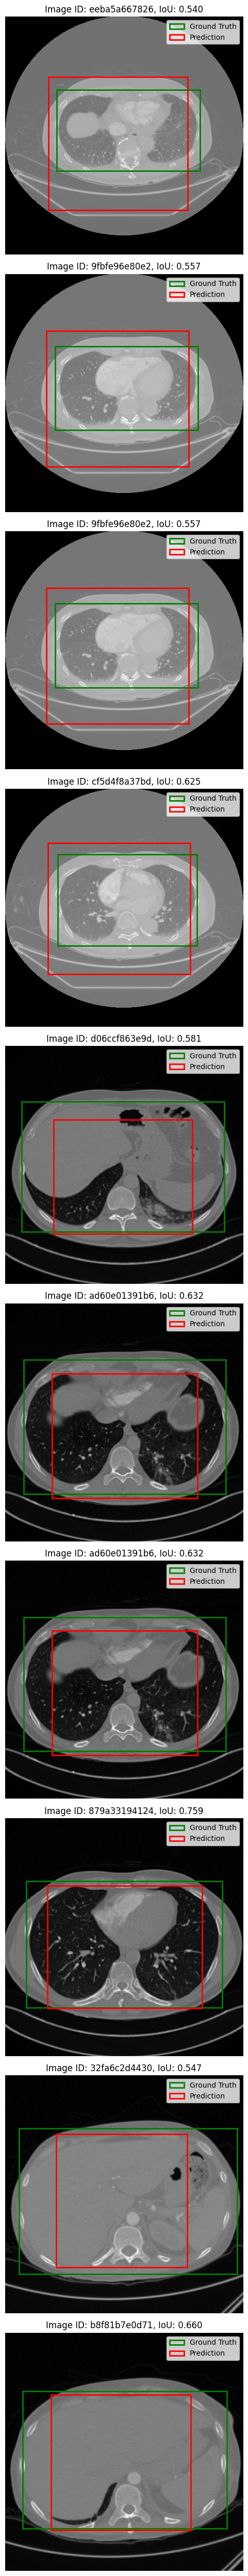

In [179]:
# Limit to the first 10 results for visualization
num_results_to_plot = min(len(results), 10)
plt.figure(figsize=(10, num_results_to_plot * 5))

for i, result in enumerate(results[:num_results_to_plot]):
    # Visualization code remains the same
    image = result['image']
    gt_bbox = result['gt_bbox']
    pred_bbox = np.clip(result['pred_bbox'], 0, 1)
    
    plt.subplot(num_results_to_plot, 1, i + 1)
    plt.imshow(image, cmap='gray')
    
    h, w = image.shape
    # Draw ground truth bounding box
    plt.gca().add_patch(plt.Rectangle(
        (gt_bbox[0] * w, gt_bbox[1] * h),
        (gt_bbox[2] - gt_bbox[0]) * w,
        (gt_bbox[3] - gt_bbox[1]) * h,
        fill=False, color='g', linewidth=2, label='Ground Truth'
    ))
    # Draw predicted bounding box
    plt.gca().add_patch(plt.Rectangle(
        (pred_bbox[0] * w, pred_bbox[1] * h),
        (pred_bbox[2] - pred_bbox[0]) * w,
        (pred_bbox[3] - pred_bbox[1]) * h,
        fill=False, color='r', linewidth=2, label='Prediction'
    ))
    
    plt.title(f"Image ID: {result['image_id']}, IoU: {result['iou']:.3f}")
    plt.legend()
    plt.axis('off')

plt.tight_layout()
plt.show()
